In [1]:
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import hist
import json

from coffea import processor
from coffea.nanoevents.methods import vector

In [2]:
dataset_short_name = {
    "ZToMuMu_M-50To120_TuneCP5_13TeV-powheg-pythia8": "ZToMuMu_M-50To120",
    "ZToMuMu_M-120To200_TuneCP5_13TeV-powheg-pythia8": "ZToMuMu_M-120To200",
    "ZToMuMu_M-200To400_TuneCP5_13TeV-powheg-pythia8": "ZToMuMu_M-200To400",
    "ZToMuMu_M-400To800_TuneCP5_13TeV-powheg-pythia8": "ZToMuMu_M-400To800",
    "ZToMuMu_M-800To1400_TuneCP5_13TeV-powheg-pythia8": "ZToMuMu_M-800To1400"
}

class BackgroundEstimatorProcessor(processor.ProcessorABC):
    def __init__(self):
        self.make_output = lambda: {
            'sumw': 0.,
            'met_kin': hist.Hist(hist.axis.Regular(40, 0, 400, name='met', label='$p_T^{miss}$ [GeV]'))
        }
        
    def get_pt_x(self, obj: ak.Array):
        return ak.sum(obj.pt * np.cos(obj.phi), axis=1)

    def get_pt_y(self, obj: ak.Array):
        return ak.sum(obj.pt * np.sin(obj.phi), axis=1)

    def get_met(self, objs: list):
        """return a Momentum2D for MET"""
        pt_x = ak.sum([self.get_pt_x(obj) for obj in objs], 
                      axis=0, 
                      mask_identity=True)
        pt_y = ak.sum([self.get_pt_y(obj) for obj in objs], 
                      axis=0, 
                      mask_identity=True)
        
        return ak.zip(
            {
                "pt": np.sqrt(pt_x ** 2 + pt_y ** 2), 
                "phi": np.arctan(pt_y / pt_x) + np.pi
            },
            with_name="Momentum2D",
            behavior=vector.behavior
        )      

    def process(self, events):   
        dataset = events.metadata['dataset']
        muon = ak.pad_none(events.Muon, target=2)
        leading_muons_mass = (muon[:, 0] + muon[:, 1]).mass

        mask = (
            (np.sum(muon.pt > 0, axis=1) == 2)
            & (ak.prod(muon.charge, axis=1) == -1)
            & (muon.pt[:, 0] > 30)
            & (muon.pt[:, 1] > 30)
            & (abs(muon.eta)[:, 0] < 2.1)
            & (abs(muon.eta)[:, 1] < 2.1)
            & ((60 < leading_muons_mass) & (leading_muons_mass < 120))
        )
        
        met = self.get_met([events[mask].Jet,
                            events[mask].Electron,
                            events[mask].Photon])
        
        output = self.make_output()
        output['sumw'] = ak.sum(events.genWeight)
        output["met_kin"].fill(met=ak.flatten(met["pt"], axis=0))
        
        return {dataset_short_name[dataset]: output}
    
    def postprocess(self, accumulator):   
        return accumulator

In [3]:
from dask.distributed import Client

client = Client("tls://daniel-2eocampo-2ehenao-40cern-2ech.dask.coffea.casa:8786")
client

<Client: 'tls://192.168.144.171:8786' processes=1 threads=2, memory=7.00 GiB>

In [4]:
with open("/home/cms-jovyan/VBFDM_UdeA/fileset/ZToMuMu.json", "r") as f:
    fileset = json.load(f)
    
for dataset, val in fileset.items():
    fileset[dataset] = ["root://xcache/" + file for file in val]

out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=BackgroundEstimatorProcessor(),
    executor=processor.dask_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
        "client": client,
    },
)

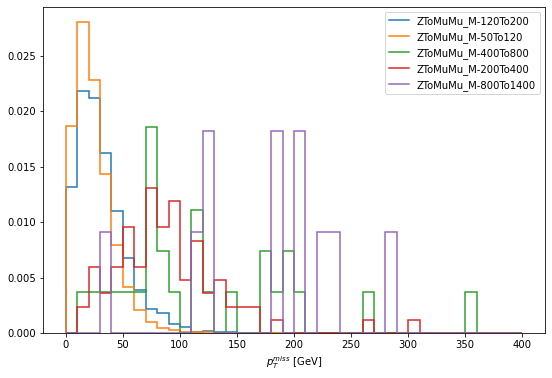

In [11]:
plt.figure(figsize=(9, 6))
for dataset in out:
    out[dataset]["met_kin"].plot1d(density=True, label=dataset)
    plt.legend();

In [6]:
xsecs = {
    "ZToMuMu_M-50To120": 2116,
    "ZToMuMu_M-120To200": 20.58,
    "ZToMuMu_M-200To400": 2.89,
    "ZToMuMu_M-400To800": 0.2515,
    "ZToMuMu_M-800To1400": 0.01709, 
}
luminosity = {
    "2016": 36330.0,
    "2017": 41480.0,
    "2018": 59830.0
}

scaled_hists = {}
for dataset, histo in out.items():
    # sample weight
    xsec = xsecs[dataset]
    lumi = luminosity["2017"]
    sumw = histo["sumw"]
    weight = (xsec * lumi) / sumw
    
    # histogram scaling
    h = histo.copy()
    h["met_kin"] *= weight
    scaled_hists[dataset] = h

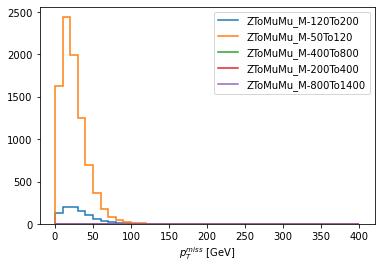

In [12]:
for dataset in out:
    scaled_hists[dataset]["met_kin"].plot1d(label=dataset)
    plt.legend();

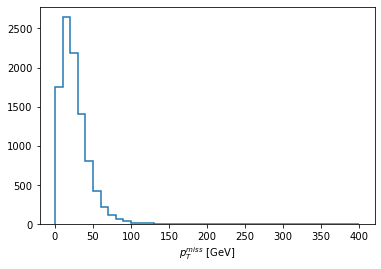

In [13]:
processor.accumulate(scaled_hists.values())["met_kin"].plot1d();